In [1]:

import os
import numpy as np
import torch
from tqdm import tqdm
import json
from dual_network import Dual3DCNN3, Dual3DCNN4, Dual3DCNN5
import torch
from torch.utils.data import Dataset
import SimpleITK as sitk
import numpy as np
import glob
from utilities import create_list_from_master_json, read_json_file, split_data
import re
import glob
import random
from torch.utils.data import Dataset, DataLoader
import numpy as np
import SimpleITK as sitk
import torch
from utilities import list_patient_folders, prepare_data_nrrd, split_data
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, ScaleIntensityd, SpatialPadd, CenterSpatialCropd, ScaleIntensityRanged
from monai.data import CacheDataset, DataLoader, Dataset
from monai.transforms import LoadImaged
from monai.data.image_reader import ITKReader
from monai.data import SmartCacheDataset
import random
from utilities import list_patient_folders, prepare_data_nrrd, split_data, prepare_data_nrrd_for_CT
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from optuna.trial import TrialState
import functools
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ReduceLROnPlateau


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# data_path_NEW = '/data/shahpouriz/DBP_newDATA/nrrd/oneCTperPatients/proton'
# data_path = '/data/shahpouriz/DBP_DATA_total/nrrd/oneCTperPatinet/proton'
# data_path = '/data/shahpouriz/DBP_DATA_total/nrrd/oneOPTZperPatinet/proton'
# data_path = '/data/shahpouriz/DBP_DATA_total/nrrd/oneoneperPatinet/proton'
# data_path = '/data/shahpouriz/DBP_DATA_total/nrrd/oneCTperPatinet/proton'
data_path = '/data/shahpouriz/DBP_CTs/nrrd/proton'


patient_list_NEW = list_patient_folders(data_path)
# Shuffle patient list if you want randomness
random.seed(42)  # You can choose any number as the seed
random.shuffle(patient_list_NEW)

# Define split sizes
total_patients = len(patient_list_NEW)
train_size = int(total_patients * 0.70)
val_size = int(total_patients * 0.20)
# The rest will be for the test set

# Split the patient list
train_patients = patient_list_NEW[:train_size]
val_patients = patient_list_NEW[train_size:train_size + val_size]
test_patients = patient_list_NEW[train_size + val_size:]

train_pct, train_rct, train_pos = prepare_data_nrrd_for_CT(data_path, train_patients)
val_pct, val_rct, val_pos = prepare_data_nrrd_for_CT(data_path, val_patients)
test_pct, test_rct, test_pos = prepare_data_nrrd_for_CT(data_path, test_patients)

# Create dictionaries for each dataset
train_data = [{"plan": img, "repeat": tar, "pos": pos} for img, tar, pos in zip(train_pct, train_rct, train_pos)]
val_data = [{"plan": img, "repeat": tar, "pos": pos} for img, tar, pos in zip(val_pct, val_rct, val_pos)]
test_data = [{"plan": img, "repeat": tar, "pos": pos} for img, tar, pos in zip(test_pct, test_rct, test_pos)]
# train_data = [{"plan": img, "repeat": tar, "pos": [p / 3 for p in pos]} for img, tar, pos in zip(train_pct, train_rct, train_pos)]
# val_data = [{"plan": img, "repeat": tar, "pos": [p / 3 for p in pos]} for img, tar, pos in zip(val_pct, val_rct, val_pos)]
# test_data = [{"plan": img, "repeat": tar, "pos": [p / 3 for p in pos]} for img, tar, pos in zip(test_pct, test_rct, test_pos)]


# Check the lengths of the sets
print("Number of training samples:", len(train_data))
print("Number of validation samples:", len(val_data))
print("Number of test samples:", len(test_data))
print(len(test_data)+len(val_data)+len(train_data))


Number of training samples: 214
Number of validation samples: 85
Number of test samples: 31
330


In [3]:
# Iterate through the training data and print the paths for planning and repeated CTs along with the position data
for i, data in enumerate(test_data):
    print(f"Sample {i+1}:")
    print(f"  Planning CT path: {data['plan']}")
    print(f"  Repeated CT path: {data['repeat']}")
    print(f"  Position data: {data['pos']}")
    print("------")  # Adding a separator for better readability between samples



Sample 1:
  Planning CT path: /data/shahpouriz/DBP_CTs/nrrd/proton/DBP_OP054/DBP_OP054_pCTp0_planningCT.nrrd
  Repeated CT path: /data/shahpouriz/DBP_CTs/nrrd/proton/DBP_OP054/DBP_OP054_pCTp0_repeatedCT_rCTp1.nrrd
  Position data: [-1.6958624  3.8764024 -8.916232 ]
------
Sample 2:
  Planning CT path: /data/shahpouriz/DBP_CTs/nrrd/proton/DBP_OP054/DBP_OP054_pCTp0_planningCT.nrrd
  Repeated CT path: /data/shahpouriz/DBP_CTs/nrrd/proton/DBP_OP054/DBP_OP054_pCTp0_repeatedCT_rCTp6.nrrd
  Position data: [-11.5017605   1.7196304  -1.5392313]
------
Sample 3:
  Planning CT path: /data/shahpouriz/DBP_CTs/nrrd/proton/DBP_OP054/DBP_OP054_pCTp0_planningCT.nrrd
  Repeated CT path: /data/shahpouriz/DBP_CTs/nrrd/proton/DBP_OP054/DBP_OP054_pCTp0_repeatedCT_rCTp10.nrrd
  Position data: [-14.464683    -0.09070918  -0.8812745 ]
------
Sample 4:
  Planning CT path: /data/shahpouriz/DBP_CTs/nrrd/proton/DBP_OP054/DBP_OP054_pCTp0_planningCT.nrrd
  Repeated CT path: /data/shahpouriz/DBP_CTs/nrrd/proton/DBP_O

In [10]:
import SimpleITK as sitk

def print_image_info(data):
    for idx, data_point in enumerate(data):
        plan_image = sitk.ReadImage(data_point['plan'])
        repeat_image = sitk.ReadImage(data_point['repeat'])
        
        print(f"Sample {idx + 1}:")
        print(f"  Plan Image - Dimensions: {plan_image.GetSize()}, Spacing: {plan_image.GetSpacing()}")
        print(f"  Repeat Image - Dimensions: {repeat_image.GetSize()}, Spacing: {repeat_image.GetSpacing()}")

# Assuming val_data is your dataset containing the paths
print_image_info(val_data)


Sample 1:
  Plan Image - Dimensions: (512, 512, 201), Spacing: (0.9765625, 0.9765625, 2.0)
  Repeat Image - Dimensions: (512, 512, 201), Spacing: (0.9765625, 0.9765625, 2.0)
Sample 2:
  Plan Image - Dimensions: (512, 512, 201), Spacing: (0.9765625, 0.9765625, 2.0)
  Repeat Image - Dimensions: (512, 512, 201), Spacing: (0.9765625, 0.9765625, 2.0)
Sample 3:
  Plan Image - Dimensions: (512, 512, 201), Spacing: (0.9765625, 0.9765625, 2.0)
  Repeat Image - Dimensions: (512, 512, 201), Spacing: (0.9765625, 0.9765625, 2.0)
Sample 4:
  Plan Image - Dimensions: (512, 512, 201), Spacing: (0.9765625, 0.9765625, 2.0)
  Repeat Image - Dimensions: (512, 512, 201), Spacing: (0.9765625, 0.9765625, 2.0)
Sample 5:
  Plan Image - Dimensions: (512, 512, 201), Spacing: (0.9765625, 0.9765625, 2.0)
  Repeat Image - Dimensions: (512, 512, 201), Spacing: (0.9765625, 0.9765625, 2.0)
Sample 6:
  Plan Image - Dimensions: (512, 512, 201), Spacing: (0.9765625, 0.9765625, 2.0)
  Repeat Image - Dimensions: (512, 512,

[ -8.590642 -10.177095  11.491684]


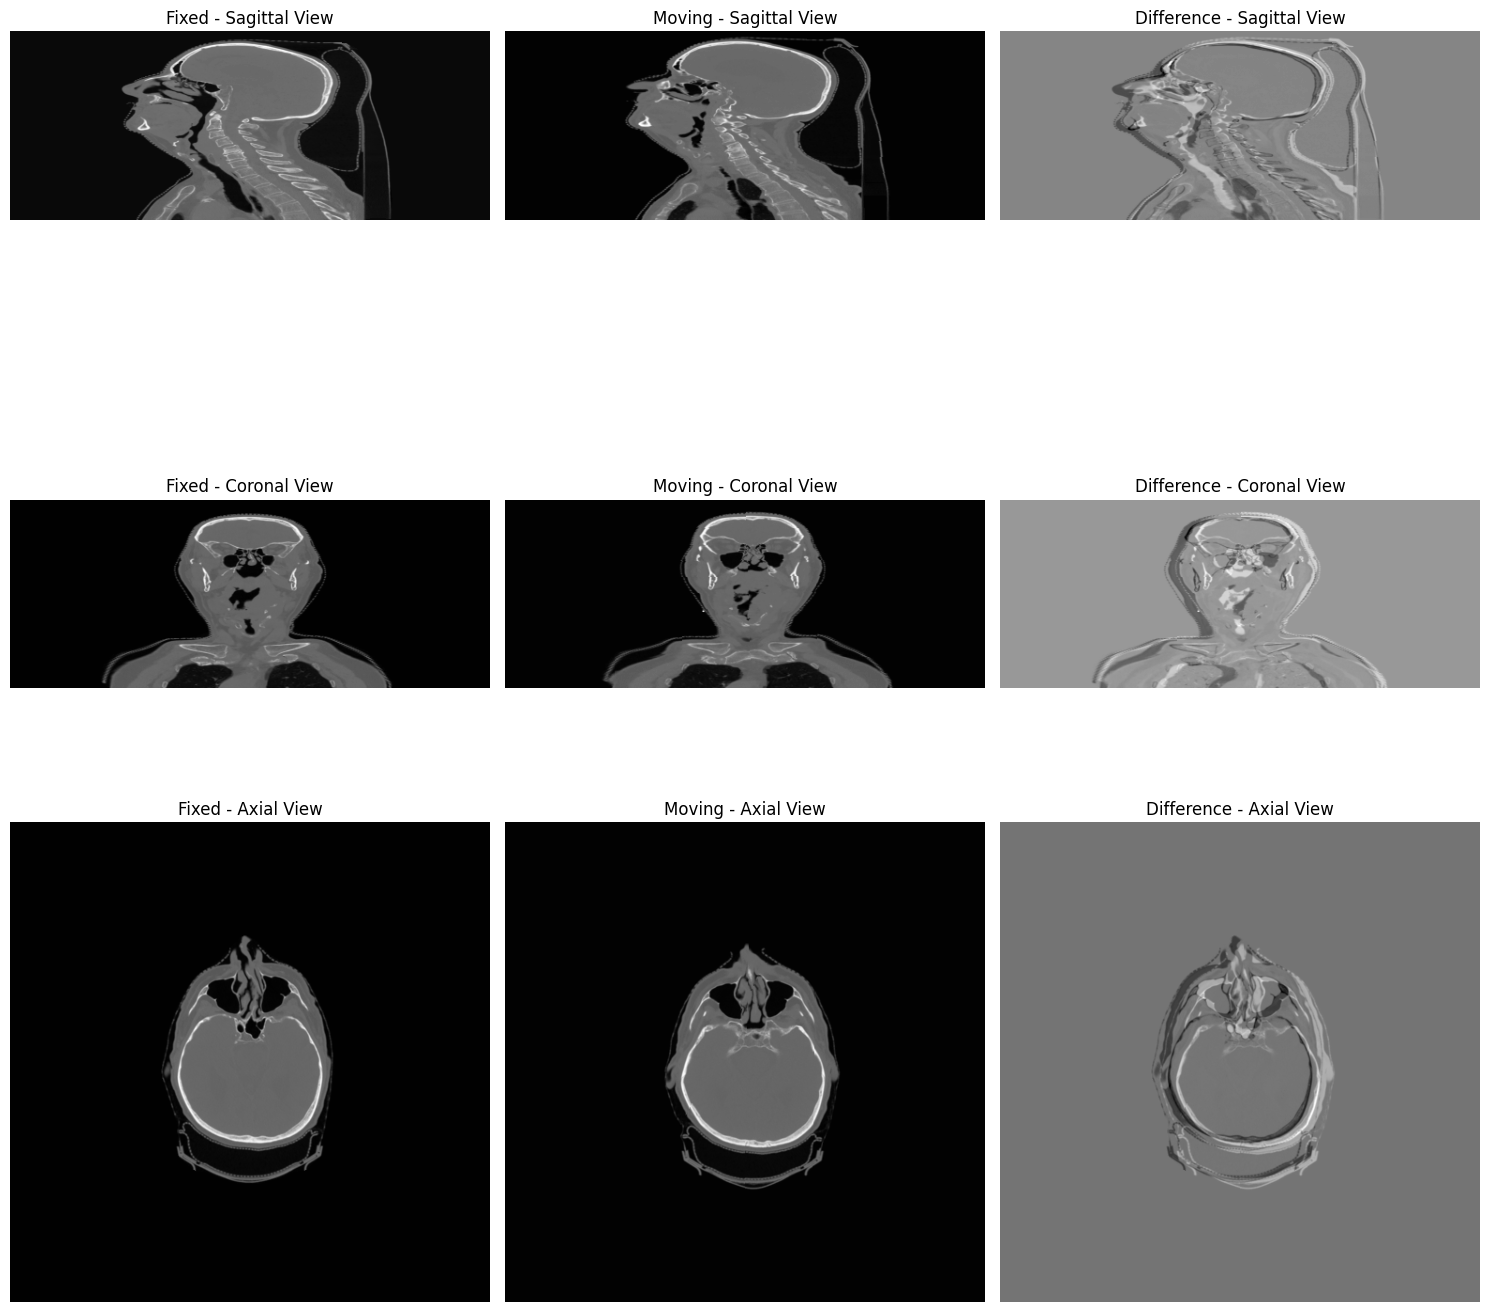

In [4]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np

# Function to selectively apply transformations to different views
def plot_slices(fixed_CT_array, moving_CT_array, slices):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    
    # Titles for the plots
    titles = ['Sagittal View', 'Coronal View', 'Axial View']
    dimensions = ['x', 'y', 'z']
    
    # Transformations for each dimension
    transformations = {
        'x': lambda img: np.rot90(np.fliplr(img), 2),  # Horizontal flip + 180-degree rotation
        'y': lambda img: np.rot90(np.fliplr(img), 2),  # Horizontal flip + 180-degree rotation, if needed
        'z': lambda img: img            # Only 180-degree rotation
    }
    
    for i, dim in enumerate(dimensions):
        slice_idx = slices[i]
        if dim == 'x':  # Sagittal
            fixed_slice = fixed_CT_array[:, :, slice_idx]
            moving_slice = moving_CT_array[:, :, slice_idx]
        elif dim == 'y':  # Coronal
            fixed_slice = fixed_CT_array[:, slice_idx, :]
            moving_slice = moving_CT_array[:, slice_idx, :]
        elif dim == 'z':  # Axial
            fixed_slice = fixed_CT_array[slice_idx, :, :]
            moving_slice = moving_CT_array[slice_idx, :, :]
        
        # Apply transformations based on the plane
        fixed_slice = transformations[dim](fixed_slice)
        moving_slice = transformations[dim](moving_slice)

        # Calculate difference for the current slice
        difference_slice = moving_slice - fixed_slice

        # Plotting
        ax1 = axes[i, 0]
        ax1.imshow(fixed_slice, cmap='gray')
        ax1.set_title(f'Fixed - {titles[i]}')
        ax1.axis('off')

        ax2 = axes[i, 1]
        ax2.imshow(moving_slice, cmap='gray')
        ax2.set_title(f'Moving - {titles[i]}')
        ax2.axis('off')

        ax3 = axes[i, 2]
        ax3.imshow(difference_slice, cmap='gray')
        ax3.set_title(f'Difference - {titles[i]}')
        ax3.axis('off')

    plt.tight_layout()
    plt.show()

# Load the images using the file paths
fixed_CT_image = sitk.ReadImage(val_data[0]['plan'])
moving_CT_image = sitk.ReadImage(val_data[0]['repeat'])
coordination = val_data[0]['pos']
# Convert SimpleITK images to numpy arrays
fixed_CT_array = sitk.GetArrayFromImage(fixed_CT_image)
moving_CT_array = sitk.GetArrayFromImage(moving_CT_image)


# Specify individual slice numbers for each view, ordered as Sagittal, Coronal, Axial
slices = [250, 200, 135]  # Specify the slices according to the desired order

# Call the function to plot the slices
print(coordination)
plot_slices(fixed_CT_array/2, moving_CT_array/2, slices)


[ -8.590642 -10.177095  11.491684]


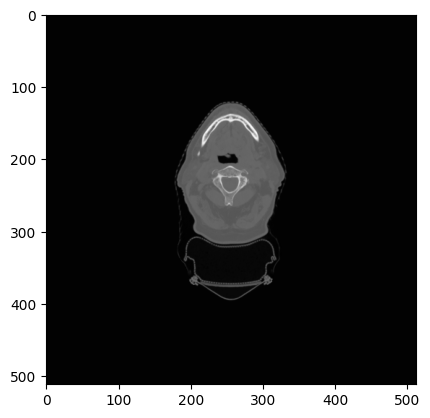

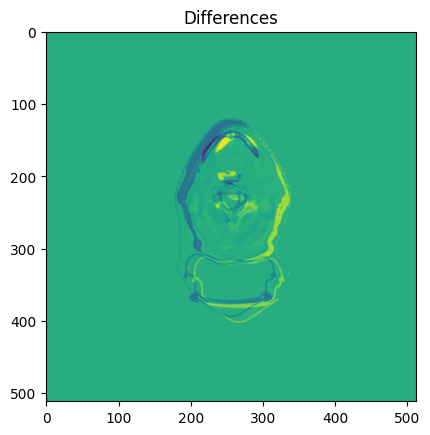

In [5]:
import matplotlib.pyplot as plt
import SimpleITK as sitk

# Load the images using the file paths
fixed_CT_image = sitk.ReadImage(val_data[0]['plan'])  # Load the image from the 'plan' filepath
moving_CT_image = sitk.ReadImage(val_data[0]['repeat'])  # Load the image from the 'repeat' filepath
coordination = val_data[0]['pos']
# Convert SimpleITK images to numpy arrays
fixed_CT_array = sitk.GetArrayFromImage(fixed_CT_image)
moving_CT_array = sitk.GetArrayFromImage(moving_CT_image)

# Calculate the difference between the two CT images
difference = moving_CT_array - fixed_CT_array

print(coordination)

plt.imshow(fixed_CT_array[100], cmap="gray")  
plt.show()

# plt.imshow(moving_CT_array[100], alpha= 0.2,  cmap="gist_yarg") 
# plt.imshow(fixed_CT_array[100], alpha= 0.2, cmap="gray")  

# #plt.imshow(difference[100])  # Adjust the index [100] as needed for the correct slice
# plt.title('two Images')
# plt.show()

plt.imshow(difference[100], )  # Adjust the index [100] as needed for the correct slice
plt.title('Differences')
plt.show()


In [13]:
# Get the spacing and size of the fixed CT image
fixed_CT_spacing = fixed_CT_image.GetSpacing()
fixed_CT_size = fixed_CT_image.GetSize()

# Get the spacing and size of the moving CT image
moving_CT_spacing = moving_CT_image.GetSpacing()
moving_CT_size = moving_CT_image.GetSize()

fixed_CT_array = sitk.GetArrayFromImage(fixed_CT_image)
moving_CT_array = sitk.GetArrayFromImage(moving_CT_image)

# Get the minimum and maximum intensity values for each image
fixed_CT_min_intensity = np.min(fixed_CT_array)
fixed_CT_max_intensity = np.max(fixed_CT_array)
moving_CT_min_intensity = np.min(moving_CT_array)
moving_CT_max_intensity = np.max(moving_CT_array)

# Print the information
print("Fixed CT Image:")
print("Spacing:", fixed_CT_spacing)
print("Dimensions:", fixed_CT_size)
print("Minimum Intensity:", fixed_CT_min_intensity)
print("Maximum Intensity:", fixed_CT_max_intensity)


print("\nMoving CT Image:")
print("Spacing:", moving_CT_spacing)
print("Dimensions:", moving_CT_size)
print("Minimum Intensity:", moving_CT_min_intensity)
print("Maximum Intensity:", moving_CT_max_intensity)

Fixed CT Image:
Spacing: (0.9765625, 0.9765625, 2.0)
Dimensions: (512, 512, 201)
Minimum Intensity: -1280
Maximum Intensity: 2089

Moving CT Image:
Spacing: (0.9765625, 0.9765625, 2.0)
Dimensions: (512, 512, 201)
Minimum Intensity: -1024
Maximum Intensity: 1924


In [6]:
from monai.transforms import NormalizeIntensityd

dim = 128
size = (dim, dim, dim)
pixdim = (3.0, 3.0, 3.0)
transforms = Compose([
        LoadImaged(keys=["plan", "repeat"], reader=ITKReader()),
        EnsureChannelFirstd(keys=["plan", "repeat"]),
        NormalizeIntensityd(keys=["plan", "repeat"]),
        Spacingd(keys=["plan", "repeat"], pixdim=pixdim, mode='trilinear'),
        SpatialPadd(keys=["plan", "repeat"], spatial_size=size, mode='constant'),  # Ensure minimum size
        CenterSpatialCropd(keys=["plan", "repeat"], roi_size=size),  # Ensure uniform size
    ])


# train_ds = CacheDataset(data=train_data, transform=transforms, cache_rate=0.5, num_workers=1)
# train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1)

val_ds = CacheDataset(data=val_data, transform=transforms, cache_rate=0.1, num_workers=1)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1)

Loading dataset: 100%|██████████| 8/8 [00:17<00:00,  2.22s/it]


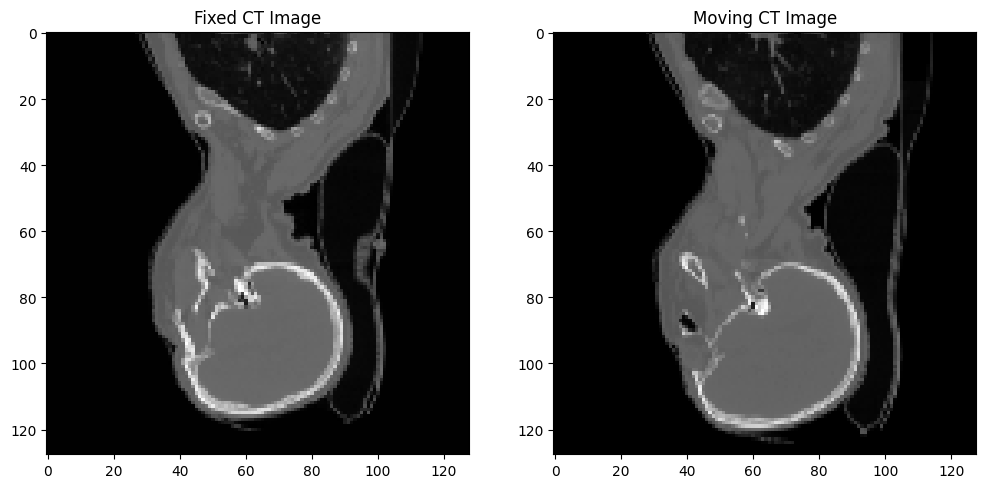

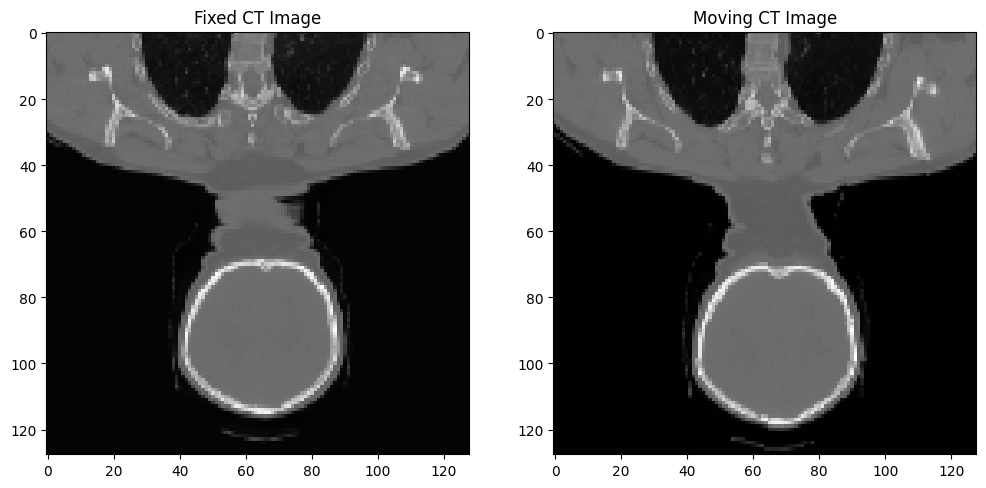

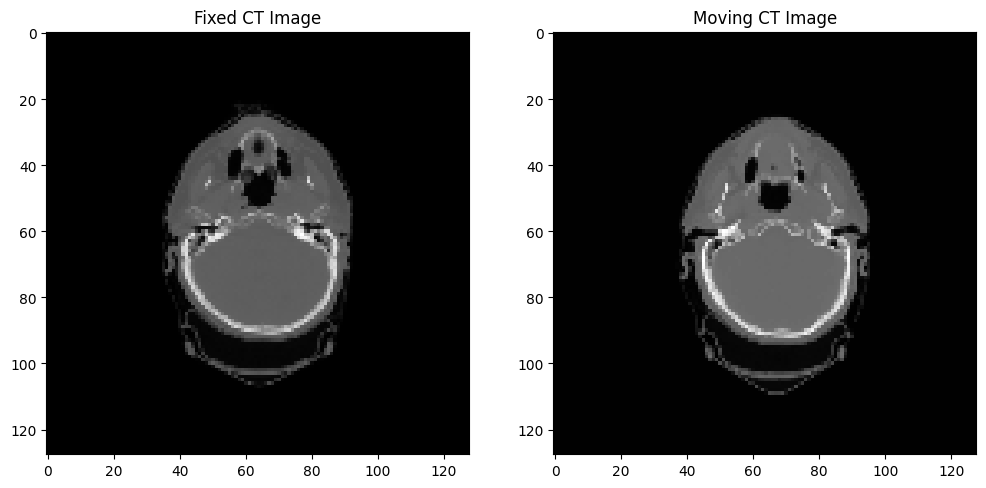

In [7]:
# Get a batch of data
batch = next(iter(val_loader))

# Convert to numpy arrays
fixed_CT_array = batch['plan'][0][0]
moving_CT_array = batch['repeat'][0][0]

x = 80  # Specify the slice number you want to visualize
y = 80
z = 80
# Plot the images
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Fixed CT Image")
plt.imshow(np.rot90(np.flip(fixed_CT_array[x, :, :],axis=1)), cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Moving CT Image")
plt.imshow(np.rot90(np.flip(moving_CT_array[x, :, :],axis=1)), cmap="gray")
plt.show()
# Plot the images
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Fixed CT Image")
plt.imshow(np.rot90(np.flip(fixed_CT_array[:, y, ],axis=1)), cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Moving CT Image")
plt.imshow(np.rot90(np.flip(moving_CT_array[:, y, :],axis=1)), cmap="gray")
plt.show()
# Plot the images
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Fixed CT Image")
plt.imshow(np.rot90(np.flip(fixed_CT_array[:, :, z],axis=1)), cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Moving CT Image")
plt.imshow(np.rot90(np.flip(moving_CT_array[:, :, z],axis=1)), cmap="gray")
plt.show()
